# Optimizing the the number of sjoins

In [1]:
import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import pygeos
from shapely.geometry import LineString, Point
from shapely.ops import polygonize

/Users/gregoriomaya/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<AxesSubplot:>

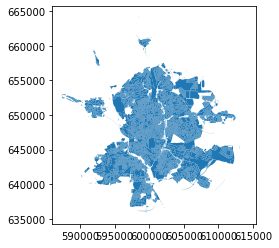

In [2]:
# loading data from file
mad = gpd.read_file(
    "/Users/gregoriomaya/Desktop/GSoc_2022/gsoc2022_network_simpl/data/madrid2062.gpkg"
)
mad.set_index(["u", "v", "key"], inplace=True)


mad_polys = polygonize(mad.geometry)
mad_polys = gpd.GeoDataFrame(geometry=[g for g in mad_polys], crs=mad.crs)
mad_polys.plot()

In [3]:
# for testing purposes only
GPD_10 = True


def _selecting_rabs_from_poly(
    gdf, circom_threshold=0.7, area_threshold=0.85, include_adjacent=True
):
    """
    From a GeoDataFrame of polygons, returns a GDF of polygons that are
    above the Circular Compaactness threshold.

    Return
    ________
    GeoDataFrames : round abouts and adjacent polygons
    """
    # calculate parameters
    gdf = gdf.copy()
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series

    # selecting round about polygons based on compactness
    rab = gdf[gdf.circom > circom_threshold]
    # exclude those above the area threshold
    area_threshold_val = gdf.area.quantile(area_threshold)
    rab = rab[rab.area < area_threshold_val]

    if include_adjacent is True:
        # calculating some parameters
        bounds = rab.geometry.bounds
        rab = pd.concat([rab, bounds], axis=1)
        rab["deltax"] = rab.maxx - rab.minx
        rab["deltay"] = rab.maxy - rab.miny
        rab["rab_diameter"] = rab[["deltax", "deltay"]].max(axis=1)

        # selecting the adjacent areas that are of smaller than itself
        if GPD_10:
            rab_adj = gpd.sjoin(gdf, rab, predicate="intersects")
        else:
            rab_adj = gpd.sjoin(gdf, rab, op="intersects")
        rab_adj = rab_adj[rab_adj.area_right >= rab_adj.area_left]
        rab_adj.index.name = "index"
        rab_adj["hdist"] = 0

        # adding a hausdorff_distance threshold
        # TODO: (should be a way to verctorize)
        for i, group in rab_adj.groupby("index_right"):
            for g in group.itertuples():
                hdist = g.geometry.hausdorff_distance(rab.loc[i].geometry)
                rab_adj.hdist.loc[g.Index] = hdist

        rab_plus = rab_adj[rab_adj.hdist < rab_adj.rab_diameter]

    else:
        rab["index_right"] = rab.index
        rab_plus = rab

    # only keeping relevant fields
    geom_col = rab_plus.geometry.name
    rab_plus = rab_plus[[geom_col, "index_right"]]

    return rab_plus


def _rabs_center_points(gdf, center_type="centroid"):
    """
    From a selection of roundabouts, returns an aggregated GeoDataFrame
    per round about with extra column with center_type.
    """
    # creating a multipolygon per RAB (as opposed to dissolving) of the entire
    # composition of the RAB
    # temporary DataFrame where geometry is the array of pygeos geometries
    tmp = pd.DataFrame(gdf.copy())  # temporary hack until shapely 2.0 is out
    tmp["geometry"] = tmp.geometry.values.data

    pygeos_geoms = (
        tmp.groupby("index_right")
        .geometry.apply(pygeos.multipolygons)
        .rename("geometry")
    )
    pygeos_geoms = pygeos.make_valid(pygeos_geoms)

    rab_multipolygons = gpd.GeoDataFrame(pygeos_geoms, crs=gdf.crs)
    # make_valid is transforming the multipolygons into geometry collections because of
    # shared edges

    if center_type == "centroid":
        # geometry centroid of the actual circle
        rab_multipolygons["center_pt"] = gdf[
            gdf.index == gdf.index_right
        ].geometry.centroid

    elif center_type == "mean":
        coords, idxs = pygeos.get_coordinates(pygeos_geoms, return_index=True)
        means = {}
        for i in np.unique(idxs):
            tmps = coords[idxs == i]
            target_idx = rab_multipolygons.index[i]
            means[target_idx] = Point(tmps.mean(axis=0))

        rab_multipolygons["center_pt"] = gpd.GeoSeries(means, crs=gdf.crs)

    # centerpoint of minimum_bounding_circle
    # minimun_bounding_circle() should be available in Shapely 2.0. Implementation still
    # pending.
    # current environment has 1.8.2

    return rab_multipolygons

In [80]:
selected_rabs = _selecting_rabs_from_poly(mad_polys)
selected_rabs_center = _rabs_center_points(selected_rabs)

/var/folders/b1/28wnz2253ss6p8t2gfh6jpg80000gn/T/ipykernel_66561/3650596907.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rab_adj.hdist.loc[g.Index] = hdist


In [104]:
# renaming to use the built-in names of the unpacked function
edges = mad.copy()

rab_idx = [33, 3407]
rab_multipolygons = selected_rabs_center.loc[rab_idx]  # isolating for testing

angle_threshold = 0  # to use later in COINS

In [111]:
# REPLICANTING WHAT HAPPENS ON _selecting_incoming_lines
# =======================================================

# selecting the lines that are touching but not covered by
if GPD_10:
    touching = gpd.sjoin(edges, rab_multipolygons, predicate="touches")
    edges_idx, rabs_idx = rab_multipolygons.buffer(1).sindex.query_bulk(
        edges.geometry, predicate="within"
    )
    idx_drop = edges.index.take(edges_idx)
else:
    touching = gpd.sjoin(edges, rab_multipolygons, op="touches")
    edges_idx, rabs_idx = rab_multipolygons.buffer(1).sindex.query_bulk(
        edges.geometry, predicate="within"
    )
    idx_drop = edges.index.take(edges_idx)

In [115]:
touching_idx = touching.index
ls = list(set(touching_idx) - set(idx_drop))
incoming = touching.loc[ls]

In [149]:
edges.sindex

In [157]:
result_idx = edges.sjoin(rab_multipolygons, predicate="covered_by").index

<AxesSubplot:>

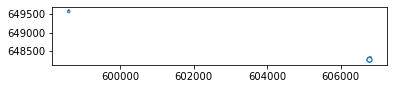

In [169]:
touching = gpd.sjoin(edges, rab_multipolygons, predicate="touches")

edges_idx, rabs_idx = rab_multipolygons.sindex.query_bulk(edges.geometry, predicate= "covered_by")

idx_drop = edges.index.take(edges_idx)
edges.loc[idx_drop].plot()